In [1]:
import time
import csv2md
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import open3d
from numpy import linalg as LA
import os
import h5py
import pandas as pd
from torch import nn
import math
import sys
sys.path.insert(1, 'C:/cherepashkin1/circles/finetune_test/')
from helpers import *

# Find orientation matrix, sort eigenvalues in ascending order, multiply by sign of the determinant to avoid ambiguity

In [ ]:
mator2 = np.zeros([len(cip), 3, 3])
for i in range(len(cip)):
    pcd0 = np.asarray(open3d.io.read_point_cloud(cip[i]).points)
    w1, v1 = LA.eig(pose6tomat(moments(pcd0-np.mean(pcd0,axis=0))))
    mator = v1[:,np.argsort(w1)]
    mator2[i,:,:] = LA.det(mator)*mator
    rotangles[i,:] = rot2eul(mator2[i])

In [2]:
df = pd.read_csv('C:/circles/finetune_test/csv/598frame.csv')
for i in range(3):
    df.insert(20+i, "eul"+str(i), rotangles[:,i])
df.to_csv('C:/circles/finetune_test/csv/598frame.csv')

# Inserting orientation matrices from subtracted mean second forms

In [112]:
df = pd.read_csv('C:/cherepashkin1/circles/finetune_test/csv/598frame.csv')

In [ ]:
a = df.loc[:,['mom' + str(i) for i in range(6)]].values
orient = np.zeros([5283,3,3])
for i in range(5283):
    _, orient[i,:,:] = LA.eig(pose6tomat(a[i,:]))
for i in range(9):
    df.insert(24+i, "orient"+str(i), orient2[:,i])

In [125]:
df.to_csv('C:/cherepashkin1/circles/finetune_test/csv/598frame.csv')

## For augement rot2eul

In [ ]:
betta = np.array([np.arccos(C[i,0,0]) for i in range(36)])
betta[0] = 0
betta[-1] = betta[1]
betta[18] = math.pi

# Calculating eul for every angle of rotation for all seeds

In [ ]:
st = time.time()
for i in range(5283):
    pcd0 = np.asarray(open3d.io.read_point_cloud(cip[i]).points)
    for j in range(36):
        pcd1 = pcd0-np.mean(pcd0,axis=0)
        pcd2 = np.matmul(pcd1, C[j,:,:].T)
        w1, v1 = LA.eig(pose6tomat(moments(pcd2)))
        mator = v1[:,np.argsort(w1)]
        mator2[i,j,:,:] = LA.det(mator)*mator
        rotangles[i,j,:] = rot2eul(mator2[i,j,:,:])
ft = time.time()
print('ellapsed time = {} s'.format(ft - st))

# Compare matrix orientation for different angles of rotation of the origin point cloud: with and without sorting eigen values

In [258]:
cip = namelist('C:/cherepashkin1/phenoseed/598', 'Surface.ply')

In [10]:
prmat = np.genfromtxt(os.path.join(csvpath, 'prmat.csv'), delimiter=',')
C = np.zeros([36,3,3])
E = [[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0]]
# TODO exchange loop with vectorization with einsum
for i in range(36):
    C[i,:,:] =\
    np.matmul(np.matmul(E,prmat[4*i:4*(i+1),:]),
        np.linalg.pinv(np.matmul(E,prmat[0:4,:])))

In [346]:
for i in range(1):
    pcd0 = np.asarray(open3d.io.read_point_cloud(cip[i]).points)
    mator4, rotangles4 = getOri(pcd0, C, eigsort = True)
    mator5, rotangles5 = getOri(pcd0, C, eigsort = False)

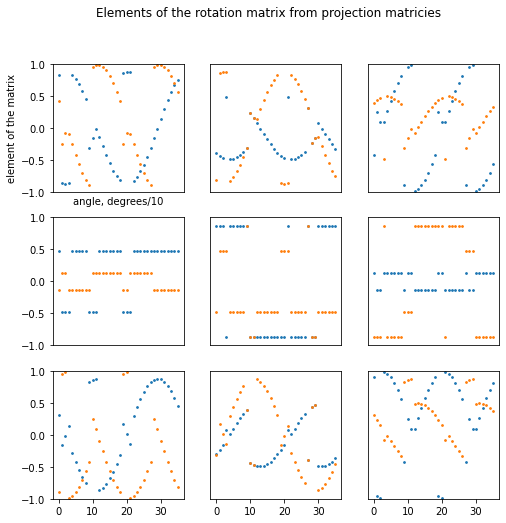

qq


In [382]:
fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(np.arange(36), mator4[:,i,j], s=3)
        ax[i,j].scatter(np.arange(36), mator5[:,i,j], s=3)
        ax[i,j].set_ylim(-1, 1)
        if i in (0,1):   
            ax[i,j].set_xticks([])
        if j in (1,2):   
            ax[i,j].set_yticks([])
ax[0,0].set_xlabel('angle, degrees/10')
ax[0,0].set_ylabel('element of the matrix')
fig.suptitle('Elements of the rotation matrix from projection matricies')
plt.show(fig)
fig.clear()
plt.close(fig)
# plt.close(fig)
print('qq')